In [2]:
## helpful packages
import pandas as pd
import numpy as np
import random
import re
import recordlinkage
from sklearn.feature_extraction.text import TfidfVectorizer
## nltk imports
from nltk.tokenize import word_tokenize, wordpunct_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim import corpora, models
# ! pip install xlrd
# ! pip install openpyxl
## lda 
from gensim import corpora
import gensim

## repeated printouts
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## define constants and pathnames
GITHUB_DATA_PATH = "../data/"
DROPBOX_DATA_PATH = "../../../qss20_finalproj_rawdata/textasdata/"
MERGED_TEXT_JOBS_PKL = "merged_addendums_jobdisclosures.pkl"
MERGED_TEXT_JOBS_CSV = "merged_addendums_jobdisclosures.csv"


# Functions

In [8]:
## Text Processing
def processtext(row, colname, stopword_list, min_token_length = 4):
    
    ## get string form of listing
    string_of_col = str(row[colname]).lower()
    try:
        ## remove stopwords 
        
        remove_stop = [word for word in wordpunct_tokenize(string_of_col)
                      if word not in stopword_list]
        processed_string = " ".join([porter.stem(i) 
                        for i in remove_stop if 
                        i.isalpha() and len(i) >= min_token_length])
        return(processed_string)
    except:
        processed_string = "" # to handle data errors where not actually text
        return(processed_string)


# Load merged data from previous script

In [7]:
merged_data = pd.read_pickle(DROPBOX_DATA_PATH + MERGED_TEXT_JOBS_PKL)
merged_data.shape

# test csv; same num rows so should be fine to load as alternative if needed
#merged_data_csv = pd.read_csv(DROPBOX_DATA_PATH + MERGED_TEXT_JOBS_CSV)
# merged_data_csv.shape

(11756, 143)

# Preprocess text

In [10]:
work_pattern = r"[a-zA-Z]*work[a-zA-Z]*"
all_listings = "".join(merged_data.JOB_DESCRIPTION)
all_tokens = word_tokenize(all_listings)

all_matches_work = [one_word for one_word in all_tokens if 
                   re.match(work_pattern, one_word)]

other_stopwords = ["after", "before", "employer", "employ", "job"]+ all_matches_work

list_stopwords = stopwords.words("english")

stopwords_complete = list_stopwords + other_stopwords
    
porter = PorterStemmer()


In [11]:

merged_data['text_preprocess'] = merged_data.apply(processtext,
                             axis = 1,
                             args = ["JOB_DESCRIPTION", stopwords_complete])
merged_data.head()

,CASE_NUMBER,CASE_STATUS,RECEIVED_DATE,DECISION_DATE,TYPE_OF_EMPLOYER_APPLICATION,H2A_LABOR_CONTRACTOR,NATURE_OF_TEMPORARY_NEED,EMERGENCY_FILING,EMPLOYER_NAME,TRADE_NAME_DBA,...,PHONE_TO_APPLY,EMAIL_TO_APPLY,WEBSITE_TO_APPLY,TOTAL_ADDENDUM_A_RECORDS,HOURLY_SCHEDULE_BEGIN,HOURLY_SCHEDULE_END,TRLA,JOB_DESCRIPTION,is_contains_spanish,text_preprocess
0,H-300-20260-827678,Determination Issued - Certification,2020-09-16 17:02:31.850,2020-09-24 00:00:00.000,Association - Joint Employer,N,Seasonal,N,WESTERN RANGE ASSOCIATION,NaN,...,12085952226,applicants@westernrange.net,NaN,0.0,NaN,NaN,False,Debe tener 3 meses de experiencia con 800 - 10...,False,debe tener mese experiencia incom transport su...
1,H-300-20260-827308,Determination Issued - Certification,2020-09-16 17:07:11.850,2020-09-24 00:00:00.000,Association - Agent,N,Seasonal,N,Allen Ranches LLC,NaN,...,13074722105,info@mpaswy.com,NaN,0.0,NaN,NaN,False,An employee may be terminated for just cause. ...,False,employe termin caus requir live ranch tool sup...
2,H-300-20260-827308,Determination Issued - Denied,2020-12-07 23:47:36.020,2020-12-28 00:00:00.000,Association - Agent,N,Seasonal,N,Allen Ranches LLC,NaN,...,13074722105,info@mpaswy.com,NaN,0.0,NaN,NaN,True,An employee may be terminated for just cause. ...,False,employe termin caus requir live ranch tool sup...
3,H-300-20259-823987,Determination Issued - Withdrawn,2020-09-18 15:28:28.690,2020-09-29 00:00:00.000,Individual Employer,N,Seasonal,N,Floyd Frey,NaN,...,14062650953,floydfrey@yahoo.com,NaN,0.0,NaN,NaN,False,"Kitchen facilities, utilities and utensils wil...",False,kitchen facil util utensil depend situat trans...
4,H-300-20259-823882,Determination Issued - Withdrawn,2020-09-21 14:52:06.660,2020-09-28 00:00:00.000,Individual Employer,N,Seasonal,N,Terence E Manas,NaN,...,16053647427,llo55@yahoo.com,NaN,0.0,NaN,NaN,False,Transportation will be provided at no cost to ...,False,transport provid cost kitchen facil util utens...


In [14]:
# Find out where "threaten" locate

merged_data[(merged_data['JOB_DESCRIPTION'].str.contains("threaten")) &
           (merged_data.TRLA)].JOB_DESCRIPTION.head()

## create TRLA and non TRLA
merged_TRLA = merged_data[merged_data.TRLA].copy()
merged_nonTRLA = merged_data[~merged_data.TRLA].copy()

## rj note- stopped here but remainder should hopefully run!

155    Employer reserves the right to pay all domesti...
269    Although not intended to be a complete list, t...
391    Although not intended to be a complete list, t...
457    Employer reserves the right to pay all domesti...
458    16.\tAny worker who physically threatens anoth...
Name: JOB_DESCRIPTION, dtype: object

# Raw term frequency

Text(0.5, 0, 'Words')

Text(0, 0.5, 'Tf-idf Score')

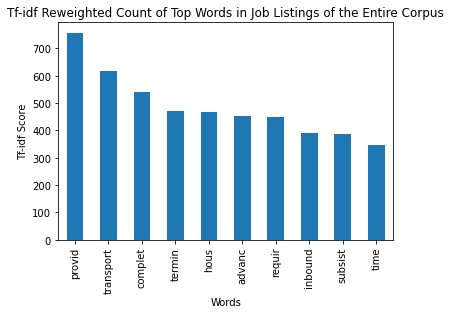

In [15]:
## Top Words In Combined Data
vectorizer = TfidfVectorizer()
tf_idf = vectorizer.fit_transform(merged_data['text_preprocess'])
top_combined = pd.DataFrame(tf_idf.toarray(), columns=vectorizer.get_feature_names())
stored=top_combined.sum(axis=0).sort_values(ascending=False).head(10)
trla_count=stored.plot.bar(title = "Tf-idf Reweighted Count of Top Words in Job Listings of the Entire Corpus")
trla_count.set_xlabel('Words')
trla_count.set_ylabel('Tf-idf Score')

provid       596.782530
transport    481.512094
termin       419.011745
advanc       405.955708
requir       389.037194
inbound      346.409261
hous         345.890161
subsist      341.369122
offer        264.954792
compens      264.881496
dtype: float64

Text(0.5, 0, 'Words')

Text(0, 0.5, 'Tf-idf Score')

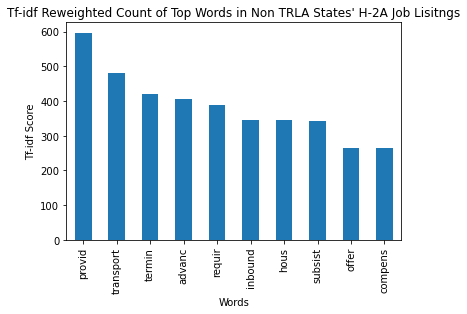

In [33]:
## topic modeling (Top Words In non TRLA)
vectorizer = TfidfVectorizer()
tf_idf = vectorizer.fit_transform(merged_nonTRLA['text_preprocess'])
top_combined_nonTRLA = pd.DataFrame(tf_idf.toarray(), columns=vectorizer.get_feature_names())
stored_nontrla=top_combined_nonTRLA.sum(axis=0).sort_values(ascending=False).head(10)
stored_nontrla
trla_count=stored_nontrla.plot.bar(title = "Tf-idf Reweighted Count of Top Words in Non TRLA States' H-2A Job Lisitngs")
trla_count.set_xlabel('Words')
trla_count.set_ylabel('Tf-idf Score')

complet     322.281283
time        258.822949
appli       248.042945
domest      245.683466
tani        245.150555
threaten    245.150555
anoth       245.132074
legal       244.840919
physic      244.544634
although    243.350935
dtype: float64

Text(0.5, 0, 'Words')

Text(0, 0.5, 'Tf-idf Score')

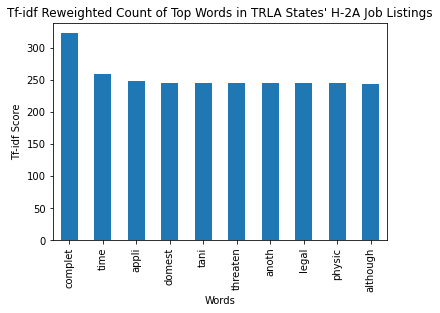

In [34]:
## topic modeling (Top Words In Non-TRLA)
vectorizer = TfidfVectorizer()
tf_idf = vectorizer.fit_transform(merged_TRLA['text_preprocess'])
top_combined_TRLA = pd.DataFrame(tf_idf.toarray(), columns=vectorizer.get_feature_names())
stored_trla=top_combined_TRLA.sum(axis=0).sort_values(ascending=False).head(10)
stored_trla
trla_count=stored_trla.plot.bar(title = "Tf-idf Reweighted Count of Top Words in TRLA States' H-2A Job Listings")
trla_count.set_xlabel('Words')
trla_count.set_ylabel('Tf-idf Score')

In [35]:
## topic modeling (TRLA states)
## rj note
merged_TRLA = merged_TRLA[merged_TRLA.text_preprocess != ""].copy()

tokenized_text_TRLA = [wordpunct_tokenize(one_text) for one_text in 
                                      merged_TRLA.text_preprocess]

## preprocess and estimate topicmod
### create dictionary
text_proc_dict_TRLA = corpora.Dictionary(tokenized_text_TRLA)
### filter dictionary- using 2% as bounds
text_proc_dict_TRLA.filter_extremes(no_below = round(merged_TRLA.shape[0]*0.02),
                             no_above = round(merged_TRLA.shape[0]*0.98))

### create corpus from dictionary
corpus_fromdict_proc = [text_proc_dict_TRLA.doc2bow(one_text) 
                   for one_text in tokenized_text_TRLA]

tfidf = models.TfidfModel(corpus_fromdict_proc)
corpus_tfidf = tfidf[corpus_fromdict_proc]

lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=3 , id2word=text_proc_dict_TRLA, passes=6,
                                        per_word_topics = True, random_state = 91988)

topics = lda_model_tfidf.print_topics(num_words = 3)
for topic in topics:
    print(topic)

(0, '0.047*"anoth" + 0.047*"threaten" + 0.046*"tani"')
(1, '0.045*"cont" + 0.024*"rule" + 0.023*"transport"')
(2, '0.095*"mechan" + 0.095*"vari" + 0.075*"time"')


In [36]:
topics_fromshow2 = [lda_model_tfidf.show_topic(topicid = i, topn = 10) for i in [0, 1, 2]]
def df_onetopic(one_listoftup, i):
    words = [one_tup[0] for one_tup in one_listoftup]
    weights = [one_tup[1] for one_tup in one_listoftup]
    words_weights_df = pd.DataFrame({'words': words, 'weights': weights})
    words_weights_df['topic'] = "topic_" + str(i)
    return(words_weights_df)
all_summary = []
for i in range(0, len(topics_fromshow2)):
    one_summary = df_onetopic(topics_fromshow2[i], i)
    all_summary.append(one_summary)
all_summary_df = pd.concat(all_summary)
all_summary_df

,words,weights,topic
0,anoth,0.046555,topic_0
1,threaten,0.046501,topic_0
2,tani,0.046492,topic_0
3,legal,0.046472,topic_0
4,appli,0.046284,topic_0
5,physic,0.045886,topic_0
6,domest,0.045855,topic_0
7,although,0.045630,topic_0
8,list,0.044865,topic_0
9,reserv,0.040827,topic_0


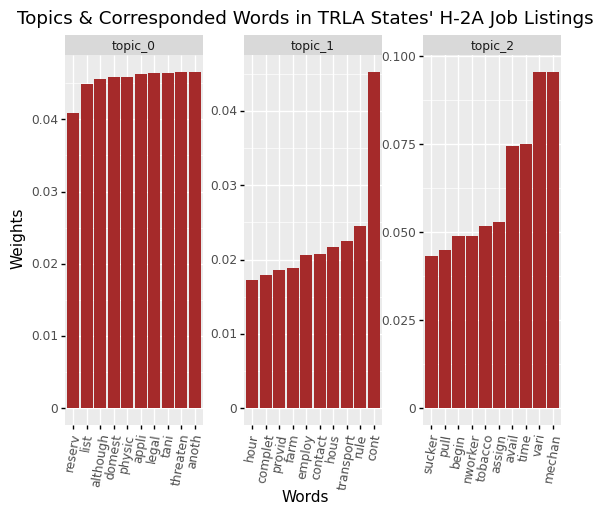

<ggplot: (8769739236602)>

In [37]:
import plotnine
from plotnine import *

ggplot(all_summary_df) +\
    geom_bar(aes(x="reorder(words,weights)",y="weights"),stat="identity", fill="brown")+ facet_wrap("topic",scales = "free")+theme(subplots_adjust={'wspace': 0.30})+\
    theme(axis_text_x = element_text(angle = 80)) + \
    labs(x="Words", y="Weights",title="Topics & Corresponded Words in TRLA States' H-2A Job Listings")

In [38]:
## topic modeling (nonTRLA states)

merged_nonTRLA = merged_nonTRLA[merged_nonTRLA.text_preprocess != ""].copy()

tokenized_text_nonTRLA = [wordpunct_tokenize(one_text) for one_text in 
                                      merged_nonTRLA.text_preprocess]

## preprocess and estimate topicmod
### create dictionary
text_proc_dict_nonTRLA = corpora.Dictionary(tokenized_text_nonTRLA)
### filter dictionary- using 2% as bounds
text_proc_dict_nonTRLA.filter_extremes(no_below = round(merged_nonTRLA.shape[0]*0.02),
                             no_above = round(merged_nonTRLA.shape[0]*0.98))

### create corpus from dictionary
corpus_fromdict_proc_non = [text_proc_dict_nonTRLA.doc2bow(one_text) 
                   for one_text in tokenized_text_nonTRLA]

tfidf_non = models.TfidfModel(corpus_fromdict_proc_non)
corpus_tfidf_non = tfidf[corpus_fromdict_proc_non]

lda_model_tfidf_non = gensim.models.LdaMulticore(corpus_tfidf_non, num_topics=3, id2word=text_proc_dict_nonTRLA, passes=6,
                                        per_word_topics = True, random_state = 91988)

topics_nontrla = lda_model_tfidf_non.print_topics()
for topic in topics_nontrla:
    print(topic)

(0, '0.066*"advanc" + 0.033*"transport" + 0.029*"complet" + 0.028*"provid" + 0.028*"hous" + 0.026*"harvest" + 0.026*"offer" + 0.021*"subsist" + 0.020*"hour" + 0.019*"commun"')
(1, '0.050*"transport" + 0.045*"requir" + 0.044*"tool" + 0.038*"wage" + 0.038*"equip" + 0.033*"bonus" + 0.030*"higher" + 0.030*"suppli" + 0.029*"employe" + 0.027*"termin"')
(2, '0.119*"inbound" + 0.075*"specif" + 0.070*"cost" + 0.068*"state" + 0.064*"outbound" + 0.057*"qualifi" + 0.051*"provid" + 0.050*"york" + 0.039*"transport" + 0.033*"item"')


In [39]:
topics_fromshow2_non = [lda_model_tfidf_non.show_topic(topicid = i, topn = 10) for i in [0, 1, 2]]
def df_onetopic(one_listoftup, i):
    words = [one_tup[0] for one_tup in one_listoftup]
    weights = [one_tup[1] for one_tup in one_listoftup]
    words_weights_df = pd.DataFrame({'words': words, 'weights': weights})
    words_weights_df['topic'] = "topic_" + str(i)
    return(words_weights_df)
all_summary_non = []
for i in range(0, len(topics_fromshow2_non)):
    one_summary_non = df_onetopic(topics_fromshow2_non[i], i)
    all_summary_non.append(one_summary_non)
all_summary_df_non = pd.concat(all_summary_non)
all_summary_df_non

,words,weights,topic
0,advanc,0.065896,topic_0
1,transport,0.032925,topic_0
2,complet,0.028915,topic_0
3,provid,0.028383,topic_0
4,hous,0.028149,topic_0
5,harvest,0.026048,topic_0
6,offer,0.025877,topic_0
7,subsist,0.021037,topic_0
8,hour,0.020109,topic_0
9,commun,0.019435,topic_0


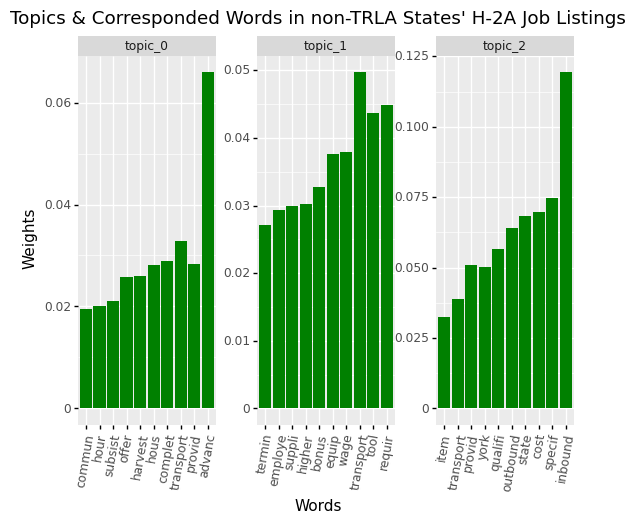

<ggplot: (8769739236515)>

In [40]:
import plotnine
from plotnine import *

ggplot(all_summary_df_non) +\
    geom_bar(aes(x="reorder(words,weights)",y="weights"),stat="identity", fill="green")+ facet_wrap("topic",scales = "free")+theme(subplots_adjust={'wspace': 0.30})+\
    theme(axis_text_x = element_text(angle = 80)) + \
    labs(x="Words", y="Weights",title="Topics & Corresponded Words in non-TRLA States' H-2A Job Listings")

In [41]:
## topic modeling (whole document)
 
merged_data = merged_data[merged_data.text_preprocess != ""].copy()

tokenized_text_all = [wordpunct_tokenize(one_text) for one_text in 
                                      merged_data.text_preprocess]

## preprocess and estimate topicmod
### create dictionary
text_proc_dict_all = corpora.Dictionary(tokenized_text_all)
### filter dictionary- using 2% as bounds
text_proc_dict_all.filter_extremes(no_below = round(merged_data.shape[0]*0.02),
                             no_above = round(merged_data.shape[0]*0.98))

### create corpus from dictionary
corpus_fromdict_proc_all = [text_proc_dict_all.doc2bow(one_text) 
                   for one_text in tokenized_text_all]

tfidf_all = models.TfidfModel(corpus_fromdict_proc_all)
corpus_tfidf_all = tfidf[corpus_fromdict_proc_all]

lda_model_tfidf_all = gensim.models.LdaMulticore(corpus_tfidf_all, num_topics=3, id2word=text_proc_dict_all, passes=6,
                                        per_word_topics = True, random_state = 91988)

#print words and topic separate...
topics_all = lda_model_tfidf_all.print_topics(num_words = 10)
for topic in topics_all:
    print(topic)

(0, '0.069*"advanc" + 0.033*"employe" + 0.032*"although" + 0.032*"physic" + 0.029*"reserv" + 0.028*"inbound" + 0.028*"outbound" + 0.028*"legal" + 0.028*"threaten" + 0.028*"right"')
(1, '0.047*"transport" + 0.035*"rule" + 0.029*"requir" + 0.029*"hous" + 0.027*"provid" + 0.025*"offer" + 0.022*"must" + 0.021*"applic" + 0.020*"inbound" + 0.018*"harvest"')
(2, '0.102*"time" + 0.065*"cont" + 0.059*"complet" + 0.057*"vari" + 0.049*"transport" + 0.041*"reimburs" + 0.040*"avail" + 0.038*"begin" + 0.036*"nworker" + 0.027*"provid"')


In [42]:
topics_fromshow2_all = [lda_model_tfidf_all.show_topic(topicid = i, topn = 10) for i in [0, 1, 2]]

def df_onetopic(one_listoftup, i):
    words = [one_tup[0] for one_tup in one_listoftup]
    weights = [one_tup[1] for one_tup in one_listoftup]
    words_weights_df = pd.DataFrame({'words': words, 'weights': weights})
    words_weights_df['topic'] = "topic_" + str(i)
    return(words_weights_df)
all_summary_all = []
for i in range(0, len(topics_fromshow2_all)):
    one_summary_all = df_onetopic(topics_fromshow2_all[i], i)
    all_summary_all.append(one_summary_all)
all_summary_df_all = pd.concat(all_summary_all)
all_summary_df_all

,words,weights,topic
0,advanc,0.068731,topic_0
1,employe,0.032710,topic_0
2,although,0.032299,topic_0
3,physic,0.031685,topic_0
4,reserv,0.028534,topic_0
5,inbound,0.028151,topic_0
6,outbound,0.028058,topic_0
7,legal,0.027972,topic_0
8,threaten,0.027624,topic_0
9,right,0.027550,topic_0


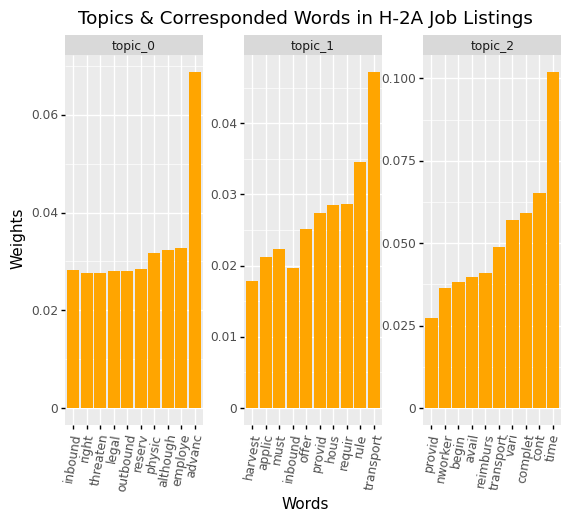

<ggplot: (8769739219035)>

In [43]:
import plotnine
from plotnine import *

ggplot(all_summary_df_all) +\
    geom_bar(aes(x="reorder(words,weights)",y="weights"),stat="identity", fill="orange")+ facet_wrap("topic",scales = "free")+theme(subplots_adjust={'wspace': 0.30})+\
    theme(axis_text_x = element_text(angle = 80)) + \
    labs(x="Words", y="Weights",title="Topics & Corresponded Words in H-2A Job Listings")